In [38]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import matplotlib
import warnings

In [39]:
df_ad = pd.read_csv('cleaned_ads_data.csv')
df_nonad = pd.read_csv('cleaned_nonads_data.csv')
df_ad['y'] = df_ad['y'].map({1:'да', 0:'нет'})
df_nonad['y'] = df_nonad['y'].map({1:'да', 0:'нет'})


In [3]:
frequent_ad = pd.Series(' '.join(df_ad.value).split()).value_counts()[:30]
frequent_nonad = pd.Series(' '.join(df_nonad.value).split()).value_counts()[:30]

<Figure size 1080x720 with 0 Axes>

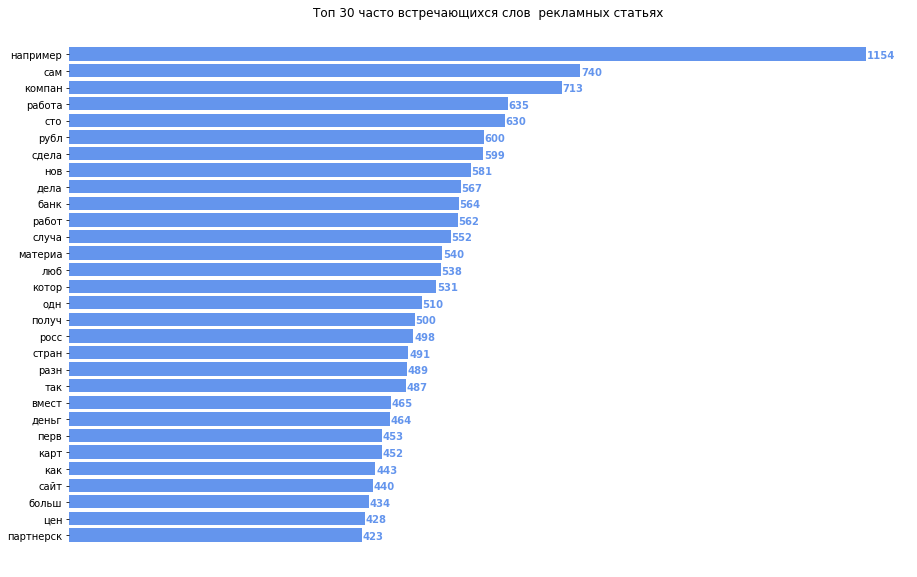

In [4]:
plt.figure(figsize=(15,10))
fig, ax = plt.subplots(figsize=(15, 10))
width = 0.05
ind = np.arange(len(frequent_ad))
ax.barh(frequent_ad.index.values, frequent_ad.values, color = '#6495ED', align = 'center')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(frequent_ad.index.values, minor = False)
for i, v in enumerate(frequent_ad.values):
    ax.text(v + 1, i + 0.27, str(v), fontweight='bold', color='#6495ED')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.invert_yaxis()
plt.title("Топ 30 часто встречающихся слов  рекламных статьях")
matplotlib.rcParams.update({'font.size': 16})
plt.show()


<Figure size 1080x720 with 0 Axes>

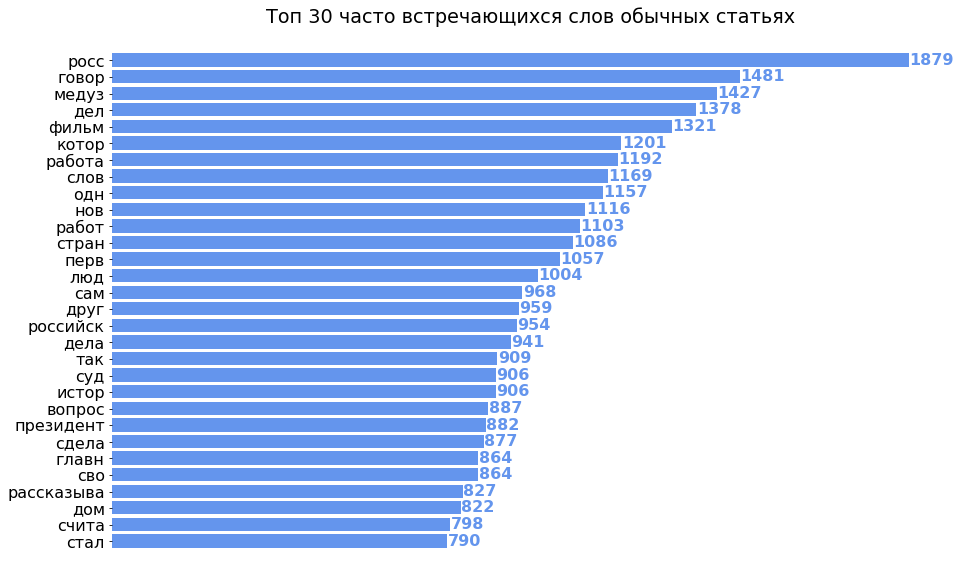

In [5]:
plt.figure(figsize=(15,10))
fig, ax = plt.subplots(figsize=(15, 10))
width = 0.05
ind = np.arange(len(frequent_nonad))
ax.barh(frequent_nonad.index.values, frequent_nonad.values, color = '#6495ED', align = 'center')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(frequent_nonad.index.values, minor = False)
for i, v in enumerate(frequent_nonad.values):
    ax.text(v + 1, i + 0.27, str(v), fontweight='bold', color='#6495ED')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.invert_yaxis()
plt.title("Топ 30 часто встречающихся слов обычных статьях")
matplotlib.rcParams.update({'font.size': 16})
plt.show()

As we can see above word материа и партнерск will give us overfitting to meduza's posts, we need to get rid of it
On meduza we can find a lot of political articles we need to get rid of word that can overfit to that articles
So we get rid of some political_words

In [40]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
overfit_ad = ['материа', 'медуз', 'партнерск']
overfit_nonad = ['росс', 'медуз', 'президент', 'российск']
for i in range(len(df_ad)):
    df_ad.ix[i].value = [item for item in df_ad.iloc[i].value.split() if item not in overfit_ad]
    df_ad.ix[i].value = [' '.join(item for item in df_ad.iloc[i].value)]
for i in range(len(df_nonad)):
    df_nonad.ix[i].value = [item for item in df_nonad.iloc[i].value.split() if item not in overfit_nonad]
    df_nonad.ix[i].value = [' '.join(item for item in df_nonad.iloc[i].value)]
df_ad['value'] = [' '.join(item) for item in df_ad['value']]
df_nonad['value'] = [' '.join(item) for item in df_nonad['value']]

In [42]:
df = pd.concat([df_ad, df_nonad])
df.reset_index(drop=True, inplace=True)
df = df.sample(frac=1).reset_index(drop=True)

In [43]:
df['count_word'] = df["value"].apply(lambda x: len(str(x).split()))
df['count_unique_word'] = df["value"].apply(lambda x: len(set(str(x).split())))
df['count_letters']=df["value"].apply(lambda x: len(str(x)))
df['mean_word_len'] = df["value"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df['unique_percent'] = df['count_unique_word'] * 100 / df['count_word']

Text(0.5,1,'Количесто слов в каждой статье')

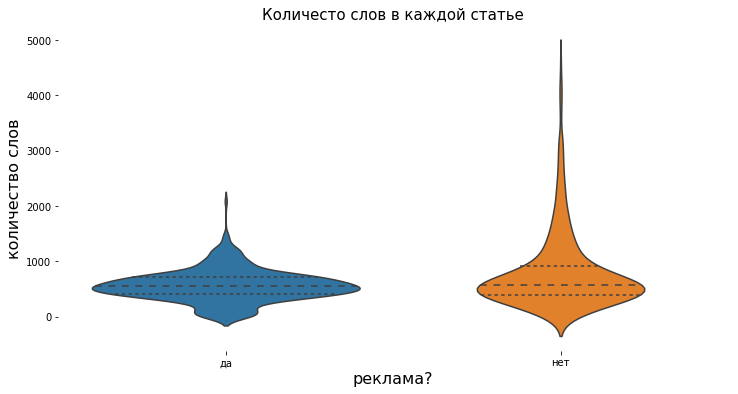

In [44]:
plt.figure(figsize=(12,6))
plt.subplot()
sns.violinplot(y='count_word', x = 'y', data = df, inner='quart')
plt.xlabel('реклама?', fontsize=16)
plt.ylabel('количество слов', fontsize=16)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.title("Количесто слов в каждой статье", fontsize=15)

As we can see above that ad articles have a count_word around 500

In [57]:
temp_df = pd.melt(df,value_vars=['count_word', 'count_unique_word'], id_vars='y')
temp_df['реклама?'] = temp_df['y']

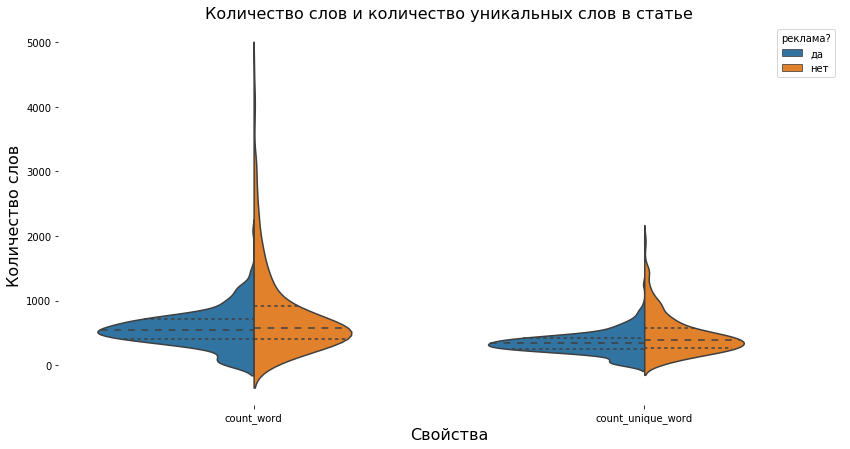

In [59]:
plt.figure(figsize=(14,7))
sns.violinplot(x='variable', y='value', hue='реклама?', data=temp_df,split=True,inner='quartile')
plt.title("Количество слов и количество уникальных слов в статье", fontsize=16)
plt.xlabel("Свойства", fontsize=16)
plt.ylabel("Количество слов", fontsize=16)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

Text(0.5,1,'Процент уникальных слов из всех слов в статьях')

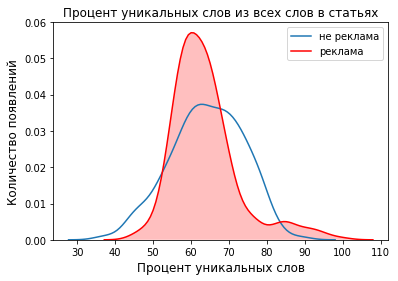

In [91]:
ax = sns.kdeplot(df[df['y'] == "нет"]['unique_percent'], label = 'не реклама')
ax = sns.kdeplot(df[df['y'] == "да"].unique_percent, label = "реклама", shade=True, color='r')
plt.ylabel('Количество появлений',fontsize=12)
plt.xlabel('Процент уникальных слов', fontsize=12)
plt.title('Процент уникальных слов из всех слов в статьях')

In [93]:
df['y'] = df['y'].map({'да':1, 'нет': 0})

In [94]:
df

,value,y,count_word,count_unique_word,count_letters,mean_word_len,unique_percent
0,начина совместн проект бизнесшкол сколков кото...,1,735,474,5689,6.741497,64.489796
1,москв июн пройдет вер шторм ежегодн профессион...,0,1590,745,11323,6.122013,46.855346
2,лосанджелес январ киноакадем объяв номинант ю ...,0,549,361,3775,5.877960,65.755920
3,иде нача воплоща бизнесмодел реш как документ ...,1,856,547,6197,6.240654,63.901869
4,феврал писател редактор издател библиотекар на...,0,413,251,3023,6.322034,60.774818
5,заверш берлинск кинофестивал показа десяток ин...,0,634,492,4491,6.085174,77.602524
6,интернет вещ называ революцион направлен писа ...,1,406,274,2991,6.369458,67.487685
7,состоян конец трудн подростк называ таков офиц...,0,4159,1864,29726,6.147632,44.818466
8,случ мужчин рак молочн желез женщин поня групп...,1,763,408,5518,6.233290,53.473132
9,магазин удобн выбра примеритькурьер ждат хоч с...,1,450,269,3055,5.791111,59.777778
